Candidate: Alessandro Paglialunga \\
Matricula: 1946185

The architecture and algorithm of this project is based on the following work (SOTA): https://paperswithcode.com/paper/gan-based-anomaly-detection-in-imbalance

#Import Dependencies

In [1]:
%%capture
!pip install pytorch-lightning

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn.modules.loss import MSELoss
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms as T
from torchvision.transforms import ToTensor
from torchvision.transforms import Lambda
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
from pytorch_lightning import LightningModule
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

#Dataset Overview

The following section will show some characteristics of the dataset under consideration. \\
in addition, some cells will show the operation of some pieces of code found in the classes below such as: _AnomalyDetector_ class

In [3]:
data_dir = 'FashionMNIST/raw/train-images-idx3-ubyte'
data_transform = T.Compose([T.ToTensor()])
# only one class is considered normal while the others are considered anomalies
normal_class_idx = 0
target_transform = Lambda(lambda y: 1.0 if y == normal_class_idx else 0.0)

In [4]:
# Training and Validation Datset
train_data = torchvision.datasets.FashionMNIST(root=data_dir,
                                               train=True,
                                               download=True,
                                               transform=data_transform,
                                               target_transform=target_transform)

# Test Dataset
test_data = torchvision.datasets.FashionMNIST(root=data_dir,
                                              train=False,
                                              transform=data_transform,
                                              target_transform=target_transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 11103254.76it/s]


Extracting FashionMNIST/raw/train-images-idx3-ubyte/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw/train-images-idx3-ubyte/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173716.24it/s]


Extracting FashionMNIST/raw/train-images-idx3-ubyte/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw/train-images-idx3-ubyte/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3253670.56it/s]


Extracting FashionMNIST/raw/train-images-idx3-ubyte/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw/train-images-idx3-ubyte/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21766408.26it/s]


Extracting FashionMNIST/raw/train-images-idx3-ubyte/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw/train-images-idx3-ubyte/FashionMNIST/raw



Image shape                 : [1, 28, 28]
Number of classes           : 10
Name of classes             : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of Training samples  : 60000
Number of Test samples      : 10000


--------------------------Sample---------------------------------
Class:  0.0


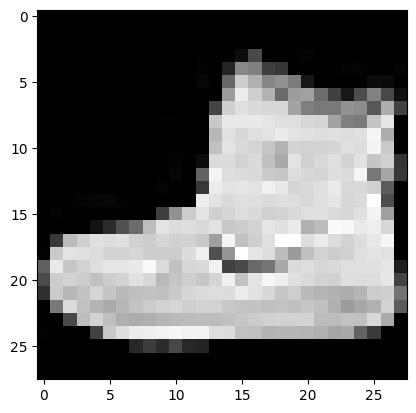

In [5]:
# Print Datasets Information
tuple_sample = train_data[0]
image_sample = tuple_sample[0]
image_shape = list(image_sample.shape)
classes_number = len(train_data.classes)
classes_name = train_data.classes
train_samples_number = len(train_data)
test_sample_number = len(test_data)

print('Image shape                 :', image_shape)
print('Number of classes           :', classes_number)
print('Name of classes             :', classes_name)
print('Number of Training samples  :', train_samples_number)
print('Number of Test samples      :', test_sample_number)

tuple_sample = train_data[0]
image_sample = tuple_sample[0]
target_sample = tuple_sample[1]
print('\n\n--------------------------Sample---------------------------------')
print("Class: ", target_sample)
plt.imshow(torch.reshape(image_sample, (28, 28, 1)), cmap='gray')

Considering that only one class is considered normal and that all classes contain the same number of samples the dataset is unbalanced

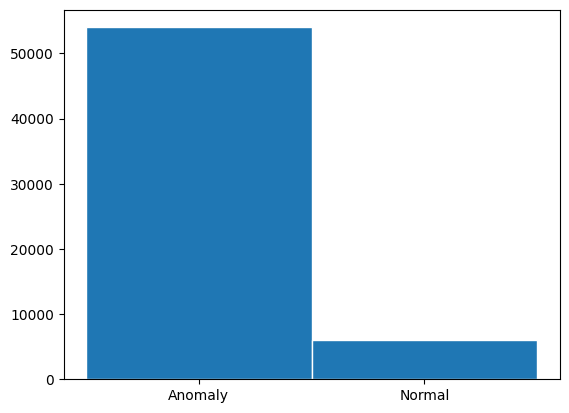

In [6]:
labels = []
for _ , target in train_data:
    labels.append(target)
labels = torch.tensor(labels)
n, _, _ = plt.hist(labels, bins=2, edgecolor='w')
plt.xticks([0.25,0.75],["Anomaly", "Normal"])
plt.show()

To solve imbalance problem, the number of samples for each anomaly class is randomly and equally reduced. \\
_taken_indices_ will contain the indices of the rows of the dataset to be considered for training. taken_indices represents a subset of the original dataset, which will be balanced between normal and anomaly samples

In [7]:
normal_class_cardinality = int(n[1])
new_cardinality_for_anomaly_classes = int(normal_class_cardinality/(classes_number -1))
original_targets = train_data.targets
curr_class_indices = (original_targets == normal_class_idx).nonzero(as_tuple=True)[0]
taken_indices = curr_class_indices
for i in range(classes_number):
    curr_class_indices = (original_targets == i).nonzero(as_tuple=True)[0]
    if i == normal_class_idx:
        continue
    new_indices_for_anomaly_class = torch.tensor(random.sample(curr_class_indices.tolist(), new_cardinality_for_anomaly_classes))
    taken_indices = torch.cat((taken_indices, new_indices_for_anomaly_class), 0)

this cell is only meant to show that the dataset is now balanced

X_train shape:  torch.Size([11994, 1, 28, 28])
y_train shape:  torch.Size([11994])


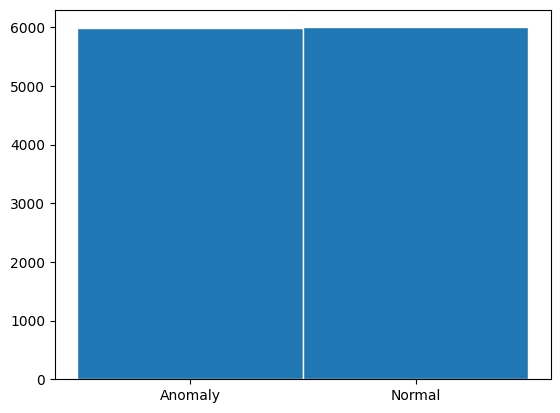

In [8]:
X_train = []
y_train = []
for i in taken_indices:
    curr_tuple = train_data[i]
    curr_x_sample = torch.unsqueeze(curr_tuple[0], 0)
    curr_y_sample = torch.unsqueeze(torch.tensor(curr_tuple[1]), 0)
    X_train.append(curr_x_sample)
    y_train.append(curr_y_sample)
X_train = torch.cat(X_train, 0)
y_train = torch.cat(y_train, 0)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
plt.hist(y_train, bins=2, edgecolor='w')
plt.xticks([0.25,0.75],["Anomaly", "Normal"])
plt.show()

the underlying _class_ will be used to create an iterable balanced datset from the original unbalanced dataset, since as the normal class (one among those available) changes, the dataset changes.

In [9]:
class DatasetFromList(Dataset):
    def __init__(self, data_list):
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

Brief overview of the following: \\
the final anomaly detector is a GAN composed of a Generator and a Discriminator. The Generator is an autoencoder mentro the discriminator is a CNN.

#Autoencoder Fashion-MNIST Data Module

This LightningDataModule is used to train and validate the autoencoder which consists of an Encoder and a Decoder.

In [10]:
class AutoencoderFashionMNISTDataModule(LightningDataModule):
    def __init__(self, data_dir, dataset):
        #print("FashionMNISTDataModule init")
        super().__init__()
        self.data_dir = data_dir
        self.data_transform = T.Compose([ T.ToTensor() ])
        self.target_transform = target_transform
        self.batch_size = 256 if torch.cuda.is_available() else 64
        self.normal_class_idx = 0 # 1 2 3 4 5 6 7 8 9
        self.dataset = dataset

    def prepare_data(self):
        torchvision.datasets.FashionMNIST(self.data_dir,
                                          train=True,
                                          download=True,
                                          transform=self.data_transform)
        torchvision.datasets.FashionMNIST(self.data_dir,
                                          train=False,
                                          download=True,
                                          transform=self.data_transform)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.FashionMNIST_full =  torchvision.datasets.FashionMNIST(self.data_dir,
                                                                   train=True,
                                                                   transform=self.data_transform)
            self.FashionMNIST_train , self.FashionMNIST_val = torch.utils.data.random_split(self.dataset, [5000, 1000])

        if stage == "test" or stage is None:
            self.FashionMNIST_test = torchvision.datasets.FashionMNIST(self.data_dir,
                                                                       train=False,
                                                                       transform=self.data_transform,
                                                                       target_transform=self.target_transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.FashionMNIST_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return  torch.utils.data.DataLoader(self.FashionMNIST_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return  torch.utils.data.DataLoader(self.FashionMNIST_test, batch_size=self.batch_size)

#Generator/Autoencoder (UNet-based architecture)

The architecture is inspired by the following work:
Ronneberger, O., Fischer, P., Brox, T.: U-net: Convolutional networks for biomedical image segmentation. In: International Conference on Medical image computing
and computer-assisted intervention. pp. 234–241. Springer (2015)


##Encoder

In [11]:
class UNetEncoder(LightningModule):
    def __init__(self):
        super().__init__()
        # Unpadded convolutions
        # Input image size = (1, 28, 28)
        self.conv1_first_step = nn.Conv2d(1, 64, 3, padding=0, stride=1) # Output image size = (64, 26, 26)
        self.bn1_first_step = nn.BatchNorm2d(64)
        self.conv1_second_step = nn.Conv2d(64, 64, 3, padding=0, stride=1) # Output image size = (64, 24, 24)
        self.bn1_second_step = nn.BatchNorm2d(64)
        self.conv2_first_step = nn.Conv2d(64, 128, 3, padding=0, stride=1) # Output image size = (128, 10, 10)
        self.bn2_first_step = nn.BatchNorm2d(128)
        self.conv2_second_step = nn.Conv2d(128, 128, 3, padding=0, stride=1) # Output image size = (128, 8, 8)
        self.bn2_second_step = nn.BatchNorm2d(128)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, input_first_stage):
        output_first_stage_first_step = self.relu(self.bn1_first_step(self.conv1_first_step(input_first_stage)))
        output_first_stage_second_step = self.relu(self.bn1_second_step(self.conv1_second_step(output_first_stage_first_step)))
        first_stage_copy_crop = torchvision.transforms.functional.crop(output_first_stage_second_step, 4, 4, 16, 16)
        input_second_stage = self.max_pool(output_first_stage_second_step)
        output_second_stage_first_step = self.relu(self.bn2_first_step(self.conv2_first_step(input_second_stage)))
        output_second_stage_second_step = self.relu(self.bn2_second_step(self.conv2_second_step(output_second_stage_first_step)))
        # first_stage_copy_crop will be used by the decoder to improve the upsampling procedure
        return [output_second_stage_second_step, first_stage_copy_crop]

##Decoder

In [12]:
class UNetDecoder(LightningModule):
    def __init__(self):
        super().__init__()
        # Unpadded convolutions
        # Input image size = (128, 8, 8)
        self.conv_transp1 = nn.ConvTranspose2d(128, 64, 2, padding=0, stride=2) # after cat Output image size = (128, 16, 16)
        self.conv1 = nn.Conv2d(128, 64, 3, padding=0, stride=1) # Output image size = (64, 14, 14)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv_transp2 = nn.ConvTranspose2d(64, 64, 2, padding=0, stride=2) # Output image size = (64, 28, 28)
        self.conv2 = nn.Conv2d(64, 1, 3, padding=1, stride=1) # Output image size = (64, 14, 14)
        self.bn2 = nn.BatchNorm2d(1)

        self.relu = nn.ReLU()

    def forward(self, input_decoder, first_stage_copy_crop):
        output_first_upsampling = self.conv_transp1(input_decoder)
        output_first_cat = torch.cat((first_stage_copy_crop, output_first_upsampling), 1)
        output_first_stage = self.relu(self.bn1(self.conv1(output_first_cat)))
        output_second_upsampling = self.conv_transp2(output_first_stage)
        output_second_stage = self.relu(self.bn2(self.conv2(output_second_upsampling)))
        return output_second_stage

##Autoencoder

In [13]:
class UNet(LightningModule):
  def __init__(self):
      super().__init__()
      self.encoder = UNetEncoder()
      self.decoder = UNetDecoder()

  def forward(self, input_encoder):
      output_encoder, first_stage_copy_crop = self.encoder(input_encoder)
      output_decoder = self.decoder(output_encoder, first_stage_copy_crop)
      return output_decoder

  def training_step(self, batch, batch_idx):
      x, y = batch
      preds = self.forward(x)
      difference = preds - x
      loss = MSELoss()(difference, torch.zeros_like(difference))
      self.log('train_loss', loss)
      return loss

  def validation_step(self, batch, batch_idx):
      x, y = batch
      preds = self.forward(x)
      difference = preds - x
      loss = MSELoss()(difference, torch.zeros_like(difference))
      self.log("val_loss", loss)

  def predict_step(self, batch, batch_idx):
      x, y = batch
      z, first_stage_copy_crop = self.encoder(x)
      preds = self.decoder(z, first_stage_copy_crop)
      return preds

  def configure_optimizers(self):
      optimizer = Adam(self.parameters(), lr=0.0001)
      return optimizer

# Discriminator Fashion-MNIST Data Module

In [14]:
class DiscriminatorFashionMNISTDataModule(LightningDataModule):
    def __init__(self, detaset, normal_class_idx):
        super().__init__()
        self.batch_size = 256 if torch.cuda.is_available() else 64
        self.detaset = detaset
        self.normal_class_idx = normal_class_idx
        self.target_transform = Lambda(lambda y: 1.0 if y == normal_class_idx else 0.0)

    def prepare_data(self):
        None

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.FashionMNIST_train , self.FashionMNIST_val = torch.utils.data.random_split(self.detaset, [10000, 1994])

        if stage == "test" or stage is None:
            self.FashionMNIST_test = torchvision.datasets.FashionMNIST(self.data_dir,
                                                                       train=False,
                                                                       transform=self.data_transform,
                                                                       target_transform=self.target_transform)
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.FashionMNIST_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return  torch.utils.data.DataLoader(self.FashionMNIST_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return  torch.utils.data.DataLoader(self.FashionMNIST_test, batch_size=self.batch_size)

#Discriminator

In [15]:
class Discriminator(LightningModule):
    def __init__(self):
        super().__init__()
        # Unpadded convolutions
        # Input image size = (1, 28, 28)
        self.conv1 = nn.Conv2d(1, 64, 5, padding=0, stride=1) # Output image size = (64,24,24)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 5, padding=0, stride=1) # Output image size = (128,20,20)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5, padding=0, stride=1) # Output image size = (128,16,16)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 5, padding=0, stride=1) # Output image size = (256,12,12)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 5, padding=0, stride=1) # Output image size = (256,8,8)
        self.bn5 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256*8*8, 100)
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, input_descriminator):
        output_conv1 = self.relu(self.bn1(self.conv1(input_descriminator)))
        output_conv2 = self.relu(self.bn2(self.conv2(output_conv1)))
        output_conv3 = self.relu(self.bn3(self.conv3(output_conv2)))
        output_conv4 = self.relu(self.bn4(self.conv4(output_conv3)))
        output_conv5 = self.relu(self.bn5(self.conv5(output_conv4))) # Output shape = (batch_size, 256, 2, 2)
        output_conv5 = output_conv5.reshape((-1, 256*8*8))
        output_FC = self.fc2(self.drop(self.relu(self.fc1(output_conv5))))
        return torch.reshape(self.sigmoid(output_FC), (output_FC.shape[0],))

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = nn.BCEWithLogitsLoss()(preds, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = nn.BCEWithLogitsLoss()(preds, y)
        self.log("val_loss", loss)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        return preds

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.0001)
        return optimizer

#Anomaly Detector (GAN-Based)


In [16]:
class AnomalyDetector(LightningModule):
    def __init__(self, data_dir='FashionMNIST/raw/train-images-idx3-ubyte',
                 gen_max_epoch=10, dis_max_epoch=10, normal_class_idx=0):
        super().__init__()
        self.generator = UNet()
        self.discriminator = Discriminator()
        self.data_dir = data_dir
        self.generator_max_epoch = gen_max_epoch
        self.discriminator_max_epoch = dis_max_epoch
        self.data_transform = T.Compose([T.ToTensor()])
        self.normal_class_idx = normal_class_idx
        self.target_transform = Lambda(lambda y: 1.0 if y == self.normal_class_idx else 0.0)
        self.set_up_dataset()

    def set_up_dataset(self):
        self.test_data = torchvision.datasets.FashionMNIST(root=self.data_dir,
                                                       train=False,
                                                       download=True,
                                                       transform=self.data_transform,
                                                       target_transform=self.target_transform)
        self.train_data = torchvision.datasets.FashionMNIST(root=self.data_dir,
                                                       train=True,
                                                       download=True,
                                                       transform=self.data_transform)

    def balance_dataset(self, dataset):
        normal_class_cardinality = sum(dataset.targets == self.normal_class_idx)
        new_cardinality_for_anomaly_classes = int(normal_class_cardinality/(len(self.train_data.classes) -1))
        original_targets = dataset.targets
        curr_class_indices = (original_targets == self.normal_class_idx).nonzero(as_tuple=True)[0]
        taken_indices = curr_class_indices
        for i in range(len(self.train_data.classes)):
            curr_class_indices = (original_targets == i).nonzero(as_tuple=True)[0]
            if i == normal_class_idx:
                continue
            new_indices_for_anomaly_class = torch.tensor(random.sample(curr_class_indices.tolist(), new_cardinality_for_anomaly_classes))
            taken_indices = torch.cat((taken_indices, new_indices_for_anomaly_class), 0)
        return taken_indices

    def split_tuple(self, dataset, specific_indeces=None):
        X = []
        y = []
        if specific_indeces == None:
            specific_indeces = range(len(dataset))
        for i in specific_indeces:
            i = int(i)
            curr_tuple = dataset[i]
            curr_x_sample = torch.unsqueeze(curr_tuple[0], 0)
            curr_y_sample = torch.unsqueeze(torch.tensor(curr_tuple[1]), 0)
            X.append(curr_x_sample)
            y.append(curr_y_sample)
        X = torch.cat(X, 0)
        y = torch.cat(y, 0)
        return [X, y]

    def forward(self, x):
        return self.discriminator(self.generator(x))

    def set_up_generator_dataset(self):
        self.generator_dataset = DatasetFromList([curr_tuple for curr_tuple in self.train_data if curr_tuple[1] == self.normal_class_idx])

    def train_generator(self):
        self.set_up_generator_dataset()
        self.generator_dm = AutoencoderFashionMNISTDataModule(self.data_dir, self.generator_dataset)
        generator_trainer = pl.Trainer(max_epochs=self.generator_max_epoch)
        generator_trainer.fit(self.generator, self.generator_dm)

    def set_up_discriminator_dataset(self):
        taken_indices = self.balance_dataset(self.train_data)
        self.train_data = torchvision.datasets.FashionMNIST(root=self.data_dir,
                                                            train=True,
                                                            download=True,
                                                            transform=self.data_transform,
                                                            target_transform=self.target_transform)
        X_train, y_train = self.split_tuple(self.train_data, taken_indices)
        for i in range(X_train.shape[0]):
            X_train[i,:,:,:] = torch.reshape(self.generator(X_train[i:i+1,:,:,:]).detach(), (1,28,28))
        self.discriminator_dataset = [(x, y) for x, y in zip(X_train, y_train)]
        self.discriminator_dataset = DatasetFromList(self.discriminator_dataset)

    def train_discriminator(self):
        self.set_up_discriminator_dataset()
        self.discriminator_dm = DiscriminatorFashionMNISTDataModule(self.discriminator_dataset, self.normal_class_idx)
        discriminator_trainer = pl.Trainer(max_epochs=self.discriminator_max_epoch)
        discriminator_trainer.fit(self.discriminator, self.discriminator_dm)

    def train_detector(self):
        self.train_generator()
        self.train_discriminator()

    def test(self):
        X_test, y_test = self.split_tuple(self.test_data, None)
        ypred = []
        first = 3000
        last = 7000
        for i in range(first, last):
            image = X_test[i:i+1, :, :, :]
            ypred.append(self.forward(image).detach())
        ypred = torch.tensor(ypred)
        return roc_auc_score(y_test[first:last], ypred)

One experiment is performed for each class. \\
In turn, each class is considered normal while the others are considered abnormal. For each experiment, a new model is trained on new balanced dataset for later testing.

In [17]:
data_dir = 'FashionMNIST/raw/train-images-idx3-ubyte'
gen_max_epoch = 10
dis_max_epoch = 10
all_roc_auc = []
for normal_class_idx in range(9):
    curr_detector = AnomalyDetector(data_dir, gen_max_epoch, dis_max_epoch, normal_class_idx)
    curr_detector.train_detector()
    curr_roc_auc = curr_detector.test()
    all_roc_auc.append(curr_roc_auc)
    print("==========================================================")
    print("Normal Class: ", normal_class_idx, "ROCAUC: ", curr_roc_auc)
    print("==========================================================")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | UNetEncoder | 259 K 
1 | decoder | UNetDecoder | 123 K 
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 1.7 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 102 K 
3  | bn2     | BatchNorm2d | 128   
4  | conv3   | Conv2d      | 204 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 409 K 
7  | bn4     | BatchNorm2d | 256   
8  | conv5   | Conv2d      | 819 K 
9  | bn5     | BatchNorm2d | 512   
10 | fc1     | L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Normal Class:  0 ROCAUC:  0.9471754202855333


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | UNetEncoder | 259 K 
1 | decoder | UNetDecoder | 123 K 
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 1.7 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 102 K 
3  | bn2     | BatchNorm2d | 128   
4  | conv3   | Conv2d      | 204 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 409 K 
7  | bn4     | BatchNorm2d | 256   
8  | conv5   | Conv2d      | 819 K 
9  | bn5     | BatchNorm2d | 512   
10 | fc1     | L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Normal Class:  1 ROCAUC:  0.9824155444236737


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | UNetEncoder | 259 K 
1 | decoder | UNetDecoder | 123 K 
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 1.7 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 102 K 
3  | bn2     | BatchNorm2d | 128   
4  | conv3   | Conv2d      | 204 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 409 K 
7  | bn4     | BatchNorm2d | 256   
8  | conv5   | Conv2d      | 819 K 
9  | bn5     | BatchNorm2d | 512   
10 | fc1     | L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Normal Class:  2 ROCAUC:  0.7926385656755087


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | UNetEncoder | 259 K 
1 | decoder | UNetDecoder | 123 K 
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 1.7 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 102 K 
3  | bn2     | BatchNorm2d | 128   
4  | conv3   | Conv2d      | 204 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 409 K 
7  | bn4     | BatchNorm2d | 256   
8  | conv5   | Conv2d      | 819 K 
9  | bn5     | BatchNorm2d | 512   
10 | fc1     | L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Normal Class:  3 ROCAUC:  0.9325107333234355


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | UNetEncoder | 259 K 
1 | decoder | UNetDecoder | 123 K 
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 1.7 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 102 K 
3  | bn2     | BatchNorm2d | 128   
4  | conv3   | Conv2d      | 204 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 409 K 
7  | bn4     | BatchNorm2d | 256   
8  | conv5   | Conv2d      | 819 K 
9  | bn5     | BatchNorm2d | 512   
10 | fc1     | L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Normal Class:  4 ROCAUC:  0.9322265558105285


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | UNetEncoder | 259 K 
1 | decoder | UNetDecoder | 123 K 
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 1.7 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 102 K 
3  | bn2     | BatchNorm2d | 128   
4  | conv3   | Conv2d      | 204 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 409 K 
7  | bn4     | BatchNorm2d | 256   
8  | conv5   | Conv2d      | 819 K 
9  | bn5     | BatchNorm2d | 512   
10 | fc1     | L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Normal Class:  5 ROCAUC:  0.9418416876660765


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | UNetEncoder | 259 K 
1 | decoder | UNetDecoder | 123 K 
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 1.7 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 102 K 
3  | bn2     | BatchNorm2d | 128   
4  | conv3   | Conv2d      | 204 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 409 K 
7  | bn4     | BatchNorm2d | 256   
8  | conv5   | Conv2d      | 819 K 
9  | bn5     | BatchNorm2d | 512   
10 | fc1     | L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Normal Class:  6 ROCAUC:  0.7876318656722721


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | UNetEncoder | 259 K 
1 | decoder | UNetDecoder | 123 K 
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 1.7 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 102 K 
3  | bn2     | BatchNorm2d | 128   
4  | conv3   | Conv2d      | 204 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 409 K 
7  | bn4     | BatchNorm2d | 256   
8  | conv5   | Conv2d      | 819 K 
9  | bn5     | BatchNorm2d | 512   
10 | fc1     | L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Normal Class:  7 ROCAUC:  0.9845986111111111


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | UNetEncoder | 259 K 
1 | decoder | UNetDecoder | 123 K 
----------------------------------------
383 K     Trainable params
0         Non-trainable params
383 K     Total params
1.534     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 1.7 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 102 K 
3  | bn2     | BatchNorm2d | 128   
4  | conv3   | Conv2d      | 204 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 409 K 
7  | bn4     | BatchNorm2d | 256   
8  | conv5   | Conv2d      | 819 K 
9  | bn5     | BatchNorm2d | 512   
10 | fc1     | L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Normal Class:  8 ROCAUC:  0.8575564719507311


Each entry in the table shows the Area Under the Receiver Operating Characteristic Curve with respect to the dataset formed by considering as a normal class the calsse with the label shown above.

In [20]:
#NC stands for Normal Class
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["NC 0", "NC 1", "NC 2", "NC 3","NC 4","NC 5","NC 6","NC 7","NC 8"]
round_all_roc_auc = np.round(all_roc_auc, decimals=2)
table.add_row(round_all_roc_auc)
table.align = "l"
print(table)

+------+------+------+------+------+------+------+------+------+
| NC 0 | NC 1 | NC 2 | NC 3 | NC 4 | NC 5 | NC 6 | NC 7 | NC 8 |
+------+------+------+------+------+------+------+------+------+
| 0.95 | 0.98 | 0.79 | 0.93 | 0.93 | 0.94 | 0.79 | 0.98 | 0.86 |
+------+------+------+------+------+------+------+------+------+
